# Проект Рекоммендательной Системы
**Мачин Иван**

## Постановка задачи
Задача: Ранжирование товаров  
Специфика задачи:
- Бинарность (2 класса: 0 - юзер не приобретал товар, 1 - приобретал)
- Implicit feedback

Таргет: Вероятность принадлежности item_id к классу 1 для выбранного user_id  
Вывод модели: Список Top-N товаров

Метрики:
MAP, MAR, F1-score (фокус на MAR), NDCG

## EDA

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('data/wb_school_task_1.csv')

In [3]:
data.head()

,user_id,item_id,order_ts
0,550614,264,2023-01-01 00:28:09.000000
1,571051,580,2023-01-01 00:41:47.000000
2,571051,180,2023-01-01 00:41:47.000000
3,47164,5135,2023-01-01 00:53:35.000000
4,219072,2668,2023-01-01 01:02:29.000000


In [4]:
print(f"Количество покупок (записей в датасете): {data.shape[0]}")
print(f"Количество уникальных пользователей (user_id): {data.nunique().user_id}")
print(f"Количество уникальных товаров (item_id): {data.nunique().item_id}")
print(f"Density: {len(data) / (len(set(data.user_id)) * len(set(data.item_id)))}")

Количество покупок (записей в датасете): 21265784
Количество уникальных пользователей (user_id): 1057265
Количество уникальных товаров (item_id): 6562
Density: 0.0030652176447060514


In [5]:
f"Временной промежуток: {data.order_ts.min(), data.order_ts.max()}"

"Временной промежуток: ('2023-01-01 00:00:05.000000', '2023-03-31 23:59:59.947831')"

In [6]:
print("Пропущенные значения: ")
data.isnull().sum()

Пропущенные значения: 


user_id     0
item_id     0
order_ts    0
dtype: int64

In [7]:
f"Число дублей: {data.duplicated().sum()}"

'Число дублей: 2006497'

In [8]:
# Создаем новый дф для трансформаций
df = data.copy()
# Конвертируем строковый timestamp в datetime формат
df['order_ts'] = pd.to_datetime(df['order_ts'])
# В данных присутствуют дубли, означающие количество подобных предметов купленных юзером в выбранный момент
# Чтобы избавиться от дублей и сохранить данные о количестве купленных предметов добавим колонку "count_"
df = df.sort_values(['user_id', 'item_id', 'order_ts'])
df['count_'] = df.groupby(['user_id', 'item_id', 'order_ts'])['user_id'].transform('count')
# Теперь удалим дублирующиеся строки
df = df.drop_duplicates(subset=['user_id', 'item_id', 'order_ts'])

In [9]:
# Сбросим индексы
df = df.reset_index(drop=True)

In [10]:
df.head()

,user_id,item_id,order_ts,count_
0,1,300,2023-02-28 09:10:25.377898,1
1,1,1853,2023-02-28 09:10:25.377898,1
2,2,217,2023-02-13 17:02:01.005005,1
3,2,356,2023-01-15 13:12:49.000000,1
4,2,511,2023-01-15 10:42:47.000000,1


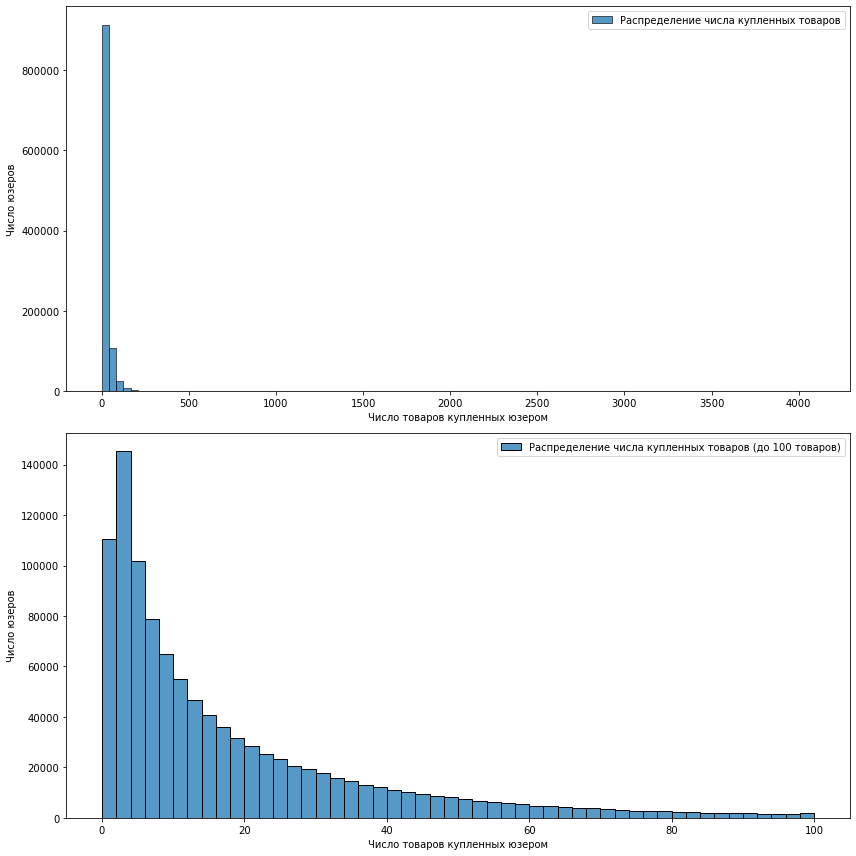

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
sns.histplot(data=df.groupby('user_id')['count_'].sum(), bins=100, ax=ax[0],
            label='Распределение числа купленных товаров')
ax[0].set_xlabel('Число товаров купленных юзером')
ax[0].set_ylabel('Число юзеров')
ax[0].legend()
sns.histplot(data=df.groupby('user_id')['count_'].sum(), bins=50, binrange=[0, 100], ax=ax[1],
            label='Распределение числа купленных товаров (до 100 товаров)')
ax[1].set_xlabel('Число товаров купленных юзером')
ax[1].set_ylabel('Число юзеров')
ax[1].legend()

plt.tight_layout()
plt.show()

In [12]:
# Характеристики распределения числа купленных товаров на юзера
df.groupby('user_id')['count_'].sum().describe()

count    1.057265e+06
mean     2.011396e+01
std      2.898362e+01
min      1.000000e+00
25%      4.000000e+00
50%      1.000000e+01
75%      2.600000e+01
max      4.088000e+03
Name: count_, dtype: float64

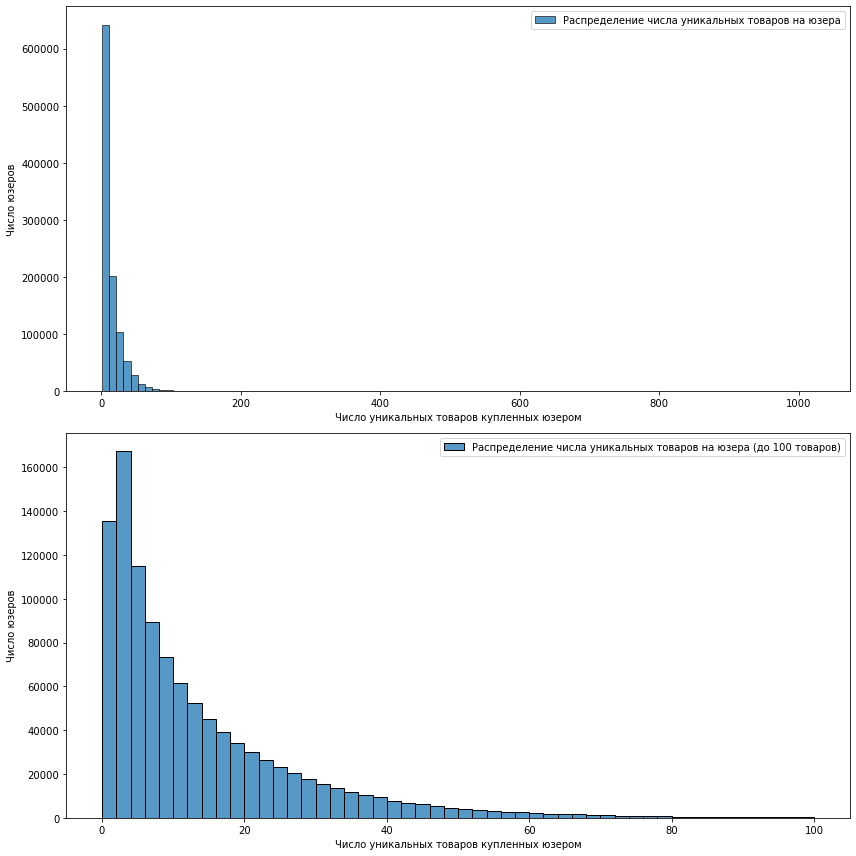

In [13]:
tmp = df.groupby('user_id')['item_id'].nunique()

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
sns.histplot(data=tmp, bins=100, ax=ax[0],
            label='Распределение числа уникальных товаров на юзера')
ax[0].set_xlabel('Число уникальных товаров купленных юзером')
ax[0].set_ylabel('Число юзеров')
ax[0].legend()
sns.histplot(data=tmp, bins=50, binrange=[0, 100], ax=ax[1],
            label='Распределение числа уникальных товаров на юзера (до 100 товаров)')
ax[1].set_xlabel('Число уникальных товаров купленных юзером')
ax[1].set_ylabel('Число юзеров')
ax[1].legend()

plt.tight_layout()
plt.show()

In [14]:
# Характеристики распределения числа купленных уникальных товаров на юзера
tmp.describe()

count    1.057265e+06
mean     1.330873e+01
std      1.529168e+01
min      1.000000e+00
25%      3.000000e+00
50%      8.000000e+00
75%      1.800000e+01
max      1.022000e+03
Name: item_id, dtype: float64

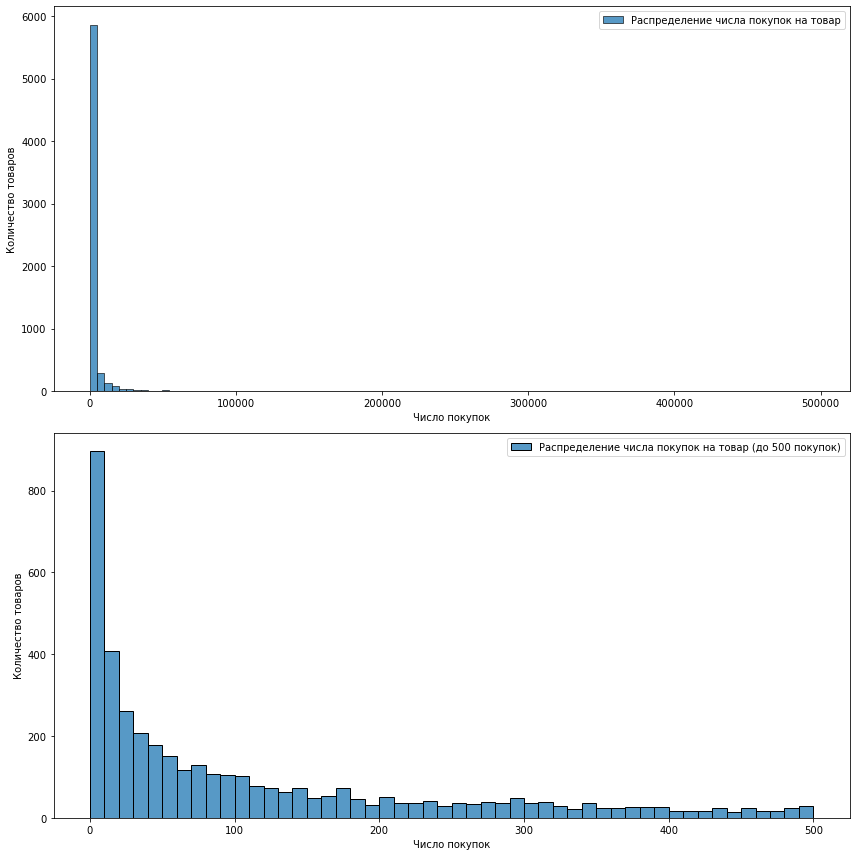

In [15]:
tmp = df.groupby('item_id').sum()['count_']


fig, ax = plt.subplots(2, 1, figsize=(12, 12))
sns.histplot(data=tmp, bins=100, ax=ax[0],
            label='Распределение числа покупок на товар')
ax[0].set_xlabel('Число покупок')
ax[0].set_ylabel('Количество товаров')
ax[0].legend()
sns.histplot(data=tmp, bins=50, binrange=[0, 500], ax=ax[1],
            label='Распределение числа покупок на товар (до 500 покупок)')
ax[1].set_xlabel('Число покупок')
ax[1].set_ylabel('Количество товаров')
ax[1].legend()

plt.tight_layout()
plt.show()

In [16]:
# Характеристики распределения покупок на товар
tmp.describe()

count      6562.000000
mean       3240.747333
std       16172.656707
min           1.000000
25%          34.000000
50%         218.000000
75%        1212.750000
max      495126.000000
Name: count_, dtype: float64

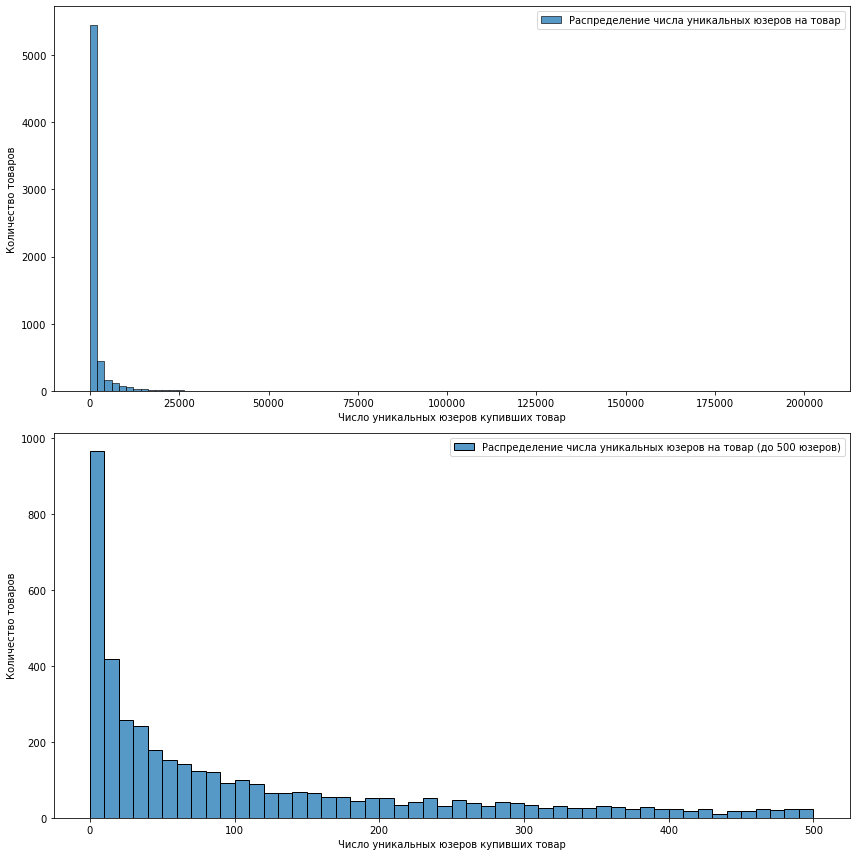

In [17]:
tmp = df.groupby('item_id')['user_id'].nunique()

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
sns.histplot(data=tmp, bins=100, ax=ax[0],
            label='Распределение числа уникальных юзеров на товар')
ax[0].set_xlabel('Число уникальных юзеров купивших товар')
ax[0].set_ylabel('Количество товаров')
ax[0].legend()
sns.histplot(data=tmp, bins=50, binrange=[0, 500], ax=ax[1],
            label='Распределение числа уникальных юзеров на товар (до 500 юзеров)')
ax[1].set_xlabel('Число уникальных юзеров купивших товар')
ax[1].set_ylabel('Количество товаров')
ax[1].legend()

plt.tight_layout()
plt.show()

In [18]:
# Характеристики распределения уникальных юзеров на товар
tmp.describe()

count      6562.000000
mean       2144.293965
std        8693.205766
min           1.000000
25%          29.000000
50%         185.000000
75%         988.750000
max      202508.000000
Name: user_id, dtype: float64

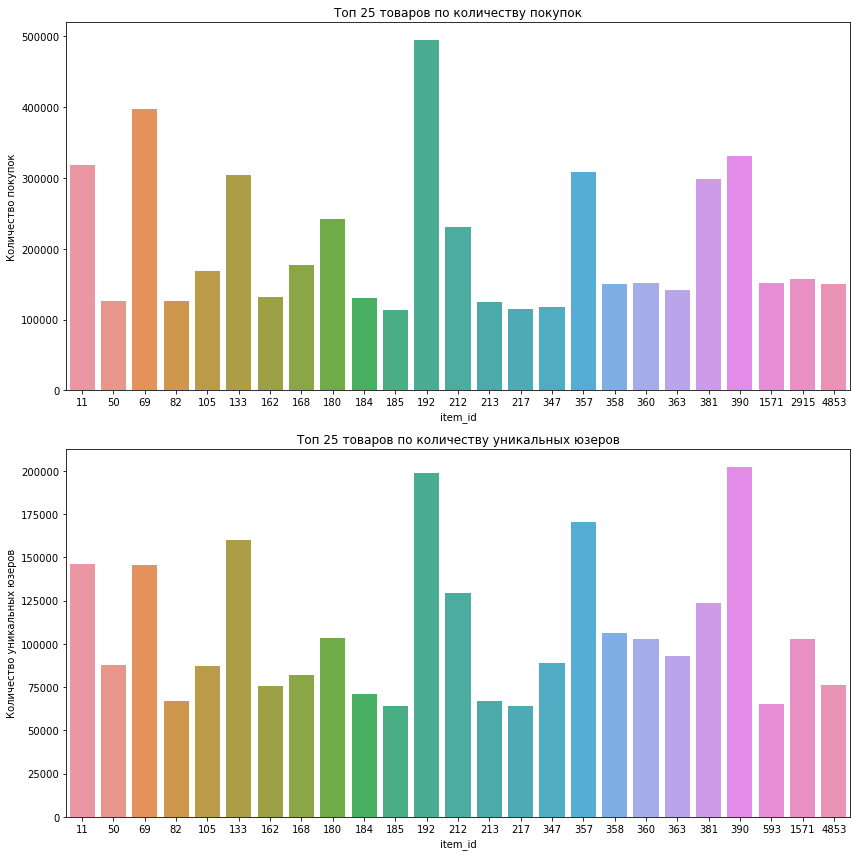

In [19]:
# Топ 25 товаров по популярности
# По количеству покупок
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
sns.barplot(x=df.groupby('item_id').sum()['count_'].nlargest(25).index,
            y=df.groupby('item_id').sum()['count_'].nlargest(25).values, ax=ax[0])
ax[0].set_xlabel('item_id')
ax[0].set_ylabel('Количество покупок')
ax[0].set_title('Топ 25 товаров по количеству покупок')

# По количеству уникальных юзеров
sns.barplot(x=df.groupby('item_id')['user_id'].nunique().nlargest(25).index, 
            y=df.groupby('item_id')['user_id'].nunique().nlargest(25).values, ax=ax[1])
ax[1].set_xlabel('item_id')
ax[1].set_ylabel('Количество уникальных юзеров')
ax[1].set_title('Топ 25 товаров по количеству уникальных юзеров')

plt.tight_layout()
plt.show()

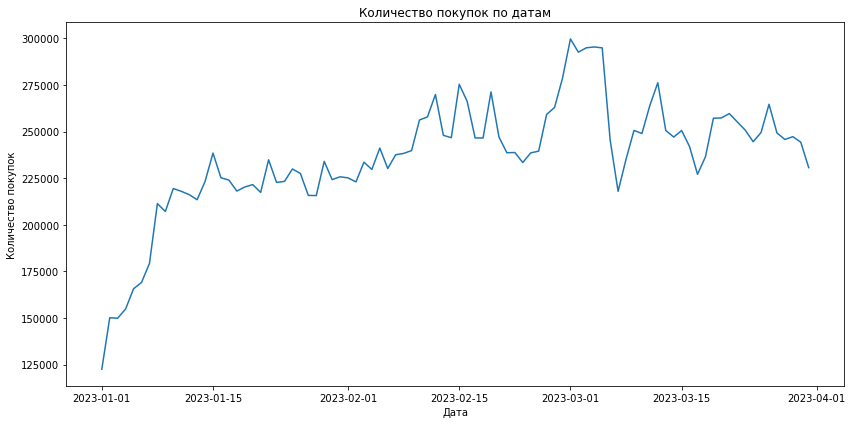

In [20]:
# Построим график покупок по датам
tmp = df.groupby([df['order_ts'].dt.date])['count_'].sum()

plt.figure(figsize=(12,6))
sns.lineplot(data=tmp)
plt.xlabel('Дата')
plt.ylabel('Количество покупок')
plt.title('Количество покупок по датам')

plt.tight_layout()
plt.show()

In [21]:
# Характеристики распределения покупок по датам
tmp.describe()

count        90.000000
mean     236286.488889
std       31455.137589
min      122484.000000
25%      223262.250000
50%      238620.500000
75%      250641.250000
max      299742.000000
Name: count_, dtype: float64

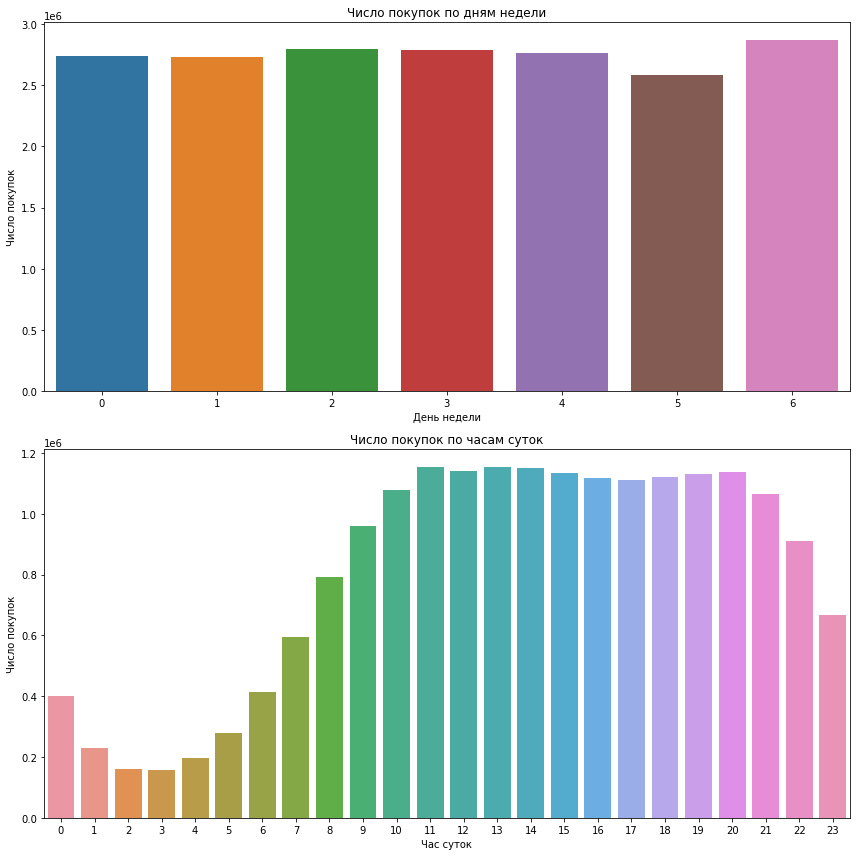

In [22]:
df['day_of_week'] = df['order_ts'].dt.dayofweek
df['hour_of_day'] = df['order_ts'].dt.hour

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# График покупок по дням недели
sns.countplot(data=df, x='day_of_week', ax=ax[0])
ax[0].set_xlabel('День недели')
ax[0].set_ylabel('Число покупок')
ax[0].set_title('Число покупок по дням недели')

# График покупок по часам суток
sns.countplot(data=df, x='hour_of_day', ax=ax[1])
ax[1].set_xlabel('Час суток')
ax[1].set_ylabel('Число покупок')
ax[1].set_title('Число покупок по часам суток')

plt.tight_layout()
plt.show()

In [23]:
df.drop(['day_of_week', 'hour_of_day'], axis=1, inplace=True)

21.56600631694222 78.43399368305778


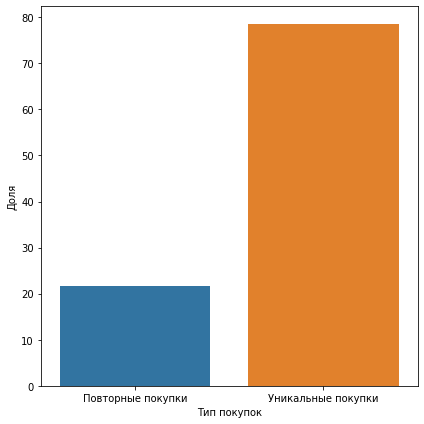

In [24]:
# Посчитаем долю повторных покупок от всех покупок юзера и возьмем среднее
# В таком случае tmp.mean() - доля повторных покупок от всех покупок по юзеру
# 100 - tmp.mean() - доля уникальных покупок от всех покупок юзера
tmp = ((df.groupby('user_id')['count_'].sum() - df.groupby('user_id')['item_id'].nunique())
       / df.groupby('user_id')['count_'].sum() * 100)

print(tmp.mean(), 100-tmp.mean())

plt.figure(figsize=(6, 6))
sns.barplot(x=['Повторные покупки', 'Уникальные покупки'], y=[tmp.mean(), 100 - tmp.mean()])
plt.xlabel('Тип покупок')
plt.ylabel('Доля')
plt.tight_layout()
plt.show()

In [25]:
# Характеристика распределения долей повторных покупок от общего числа покупок
tmp.describe()

count    1.057265e+06
mean     2.156601e+01
std      1.888462e+01
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e+01
75%      3.461538e+01
max      9.876543e+01
dtype: float64

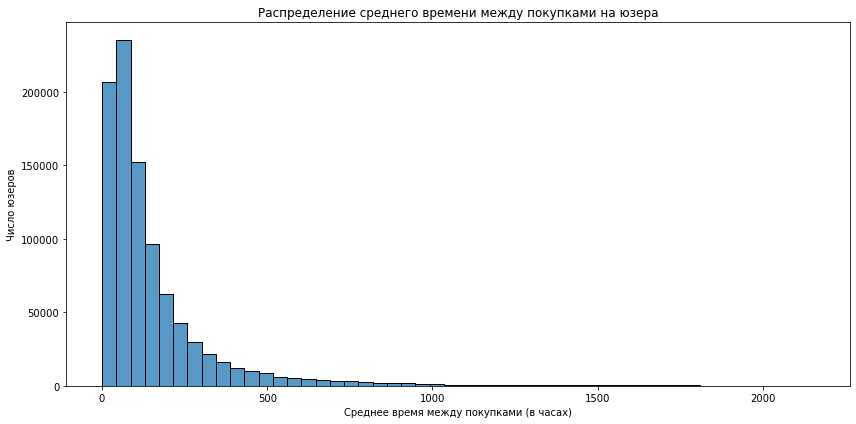

In [26]:
# Сортируем данные в хронологическом порядке
df_sorted = df.sort_values(['user_id', 'order_ts'])

# Считаем интервалы между покупками для юзеров
df_sorted['time_diff'] = df_sorted.groupby('user_id')['order_ts'].diff().dt.total_seconds() / 3600

# Считаем средний интервал на юзера
tmp = df_sorted.groupby('user_id')['time_diff'].mean()

plt.figure(figsize=(12, 6))
sns.histplot(data=tmp.dropna(), bins=50)
plt.xlabel('Среднее время между покупками (в часах)')
plt.ylabel('Число юзеров')
plt.title('Распределение среднего времени между покупками на юзера')
plt.tight_layout()
plt.show()

In [27]:
# Характеристики распределения среднего времени между покупками
tmp.describe()

count    939722.000000
mean        154.647038
std         199.961454
min           0.000000
25%          47.774436
50%          92.798864
75%         180.781708
max        2154.752142
Name: time_diff, dtype: float64

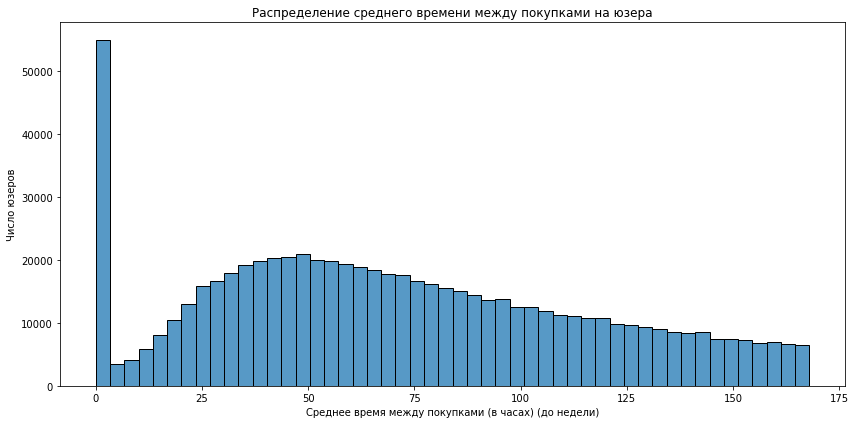

In [28]:
plt.figure(figsize=(12, 6))
sns.histplot(data=tmp.dropna(), bins=50, binrange=[0, 168])
plt.xlabel('Среднее время между покупками (в часах) (до недели)')
plt.ylabel('Число юзеров')
plt.title('Распределение среднего времени между покупками на юзера')
plt.tight_layout()
plt.show()

### Результаты EDA

- Распределение общего числа покупок сильно смещено вправо, среднее число покупок составляет 20, при медиане в 10.
- Распределение уникальных товаров на одного пользователя смещено слабее (среднее 13, медиана 8), что свидетельствует о том, что юзеры, совершившие большое число покупок, покупали некоторые товары многократно
- Распределение количества покупок на товар также сильно смещено вправо (среднее 3241, медиана 218), что свидетельствует о наличии бестселлеров, на порядки популярнее большинства товаров, на сравнительных графиках сильно выделяются менее 10 товаров
- Если смотреть только на количество уникальных пользователей купивших товар и на распределение данной величины (среднее 2184, медиана 185), оно смещено меньше но также сильно, и в нем явно выделяются бестселлеры)
- Глядя на распределение долей повторных покупок от общего числа покупок, средняя доля составляет около 20 %, что достигается за счет пользователей совершивших малое число покупок, при чем максимально составляет 98%
- Данные представлены за 3 месяца, есть сильная просадка покупок в первую неделю января, затем количество покупок от дате к дате более менее стабильно (среднее всего распределения 236к при медиане 238к)
- При рассмотрении количества покупок по дням недели, значения различаются незначительно (лучший день - воскресенье, худший день - суббота)
- При рассмотрении количества покупок по часам суток, сильно выпадает ночное время
- При рассмотрении среднего времени между покупками на юзера, среднее среднее время между покупками составляет 6,5 суток, медианное среднее время - 3,8 суток. Есть выброс, большое значение юзеров с 0 часов среднего промежуточного времени, так как они совершили одну покупку, распределение в целом скошено вправо. Несмотря на юзеров с одной покупкой, глядя на распределение, можно заметить что время резко возрастает до пикового значения около двух суток, затем плавно снижается.

### Препроцессинг

1. Удаление полных дублей посредством добавления колонки count_, которая хранит информацию количества товара в одном заказе
2. Удалим все товары которые заказало менее 5 пользователей (605 товаров из 6562)

In [71]:
tmp = df.groupby('item_id')['user_id'].nunique()

In [94]:
tmp[tmp < 5].index.shape

(605,)

In [95]:
unpopular_items = set(tmp[tmp < 5].index)

In [96]:
filtered_df = df[~df['item_id'].isin(unpopular_items)]

In [101]:
f"Размеры полученного датасета: {filtered_df.shape}"

'Размеры полученного датасета: (19257808, 4)'

In [100]:
f"Итого удалено: {data.shape[0] - filtered_df.shape[0]} записей"

'Итого удалено: 2007976 записей'

In [102]:
filtered_df.to_csv('data/filtered_data')